In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
##from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers,models,datasets

In [3]:
train_dataset_path = 'C:/Users/HP/Desktop/PYTHON/THESIS/Book/Training'
validation_dataset_path = 'C:/Users/HP/Desktop/PYTHON/THESIS/Book/Validation'

In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE =32 
EPOCHS = 1

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=30,
                                  horizontal_flip=True,  # random_flip can also be used
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 1080 images belonging to 3 classes.


In [6]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Early_blight', 'Healthy', 'Late_blight']


In [7]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 110 images belonging to 3 classes.


In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Early_blight
1 : Healthy
2 : Late_blight


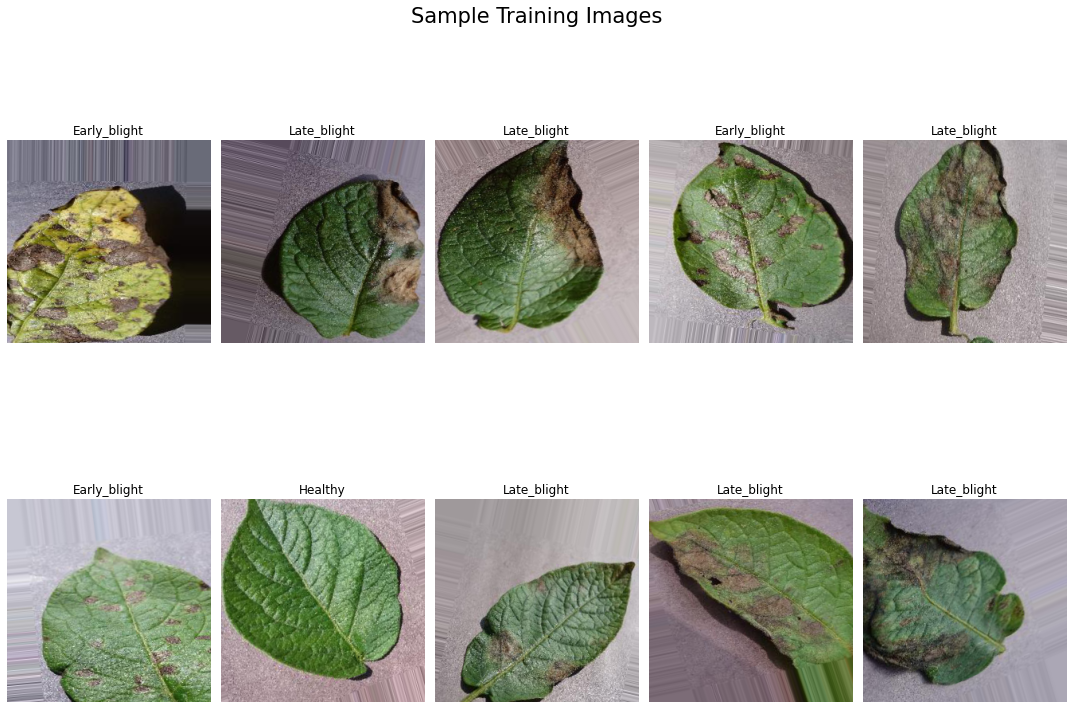

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [10]:
def create_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(5, 5), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=70, activation='relu'),
        Dropout(0.5),
        Dense(units=3, activation='softmax')
    ])
    
    return model

In [11]:
cnn_model = create_model()

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [13]:
cnn_model.compile(optimizer='adam', 
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [14]:
history = cnn_model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

34/34 - 465s - loss: 1.9813 - accuracy: 0.7769 - val_loss: 4.4052 - val_accuracy: 0.4545 - lr: 0.0010 - 465s/epoch - 14s/step


In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

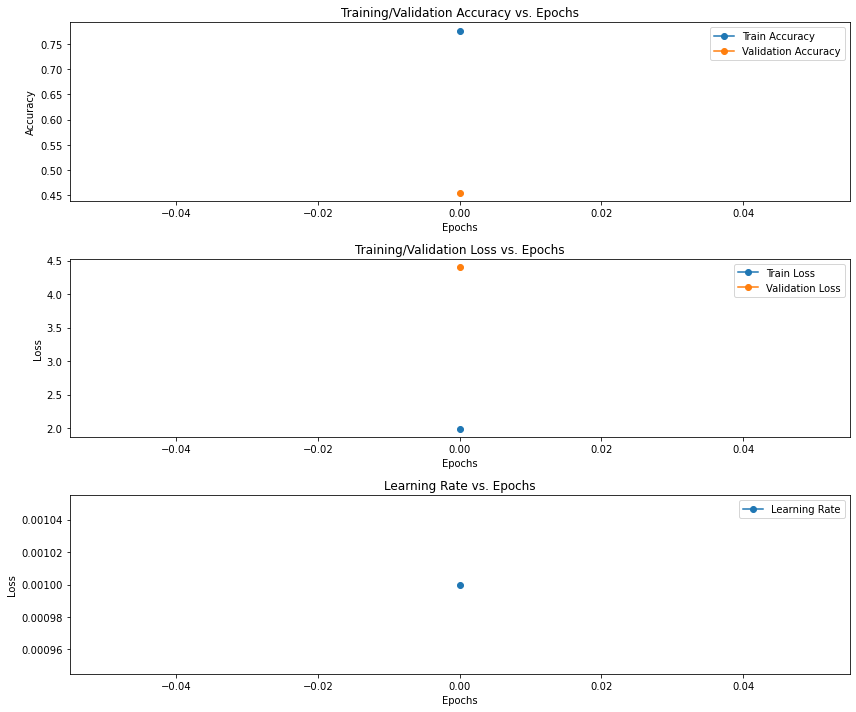

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training/Validation Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [17]:
test_dataset = 'C:/Users/HP/Desktop/PYTHON/THESIS/Book/Testing'

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 160 images belonging to 3 classes.


In [19]:
predictions = cnn_model.predict(test_generator)
Y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

5/5 [==============================] - 17s 4s/step


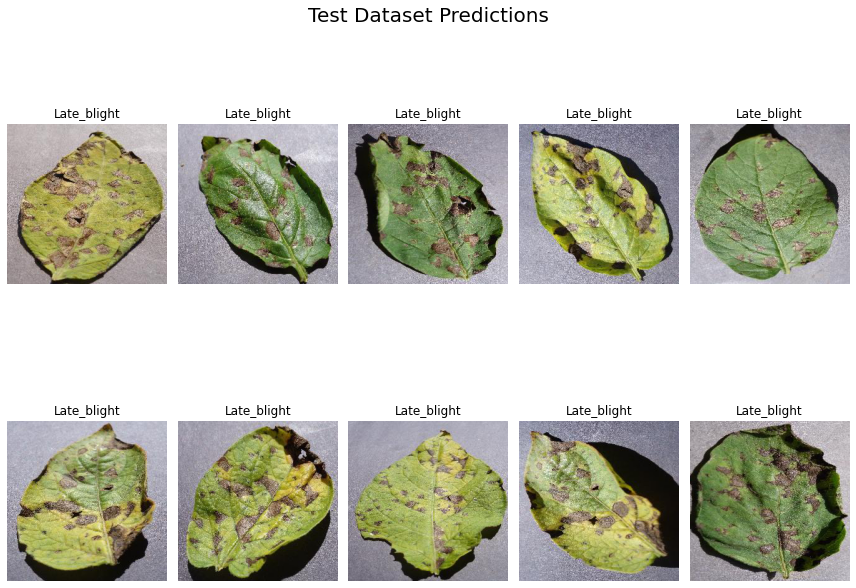

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [21]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

5/5 [==============================] - 17s 4s/step - loss: 4.5893 - accuracy: 0.4375


In [22]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     4.589258670806885
Test Accuracy: 0.4375


[[ 0  0 70]
 [ 0  0 20]
 [ 0  0 70]]


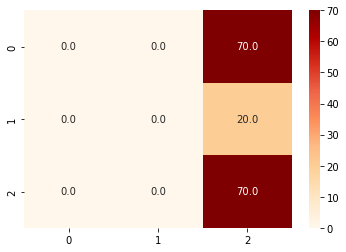

In [23]:
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
sns.heatmap(c_matrix, annot=True,cmap="OrRd",fmt=".1f")
plt.show()

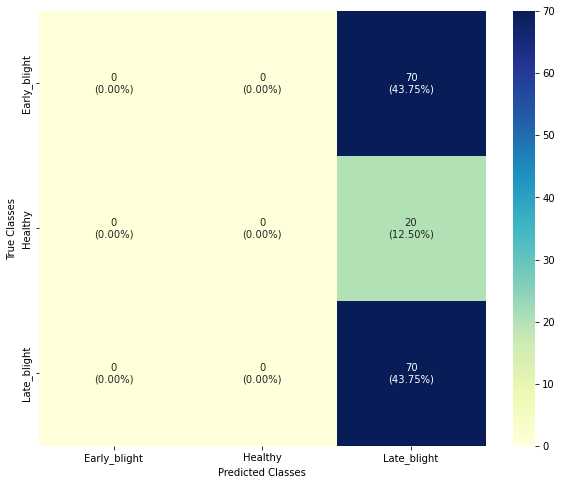

In [24]:
cf_mtx = confusion_matrix(y_true, Y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(3,3)

plt.figure(figsize = (10, 8))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
          cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [25]:
print(classification_report(y_true, Y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

Early_blight       0.00      0.00      0.00        70
     Healthy       0.00      0.00      0.00        20
 Late_blight       0.44      1.00      0.61        70

    accuracy                           0.44       160
   macro avg       0.15      0.33      0.20       160
weighted avg       0.19      0.44      0.27       160



In [26]:
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc,accuracy_score

In [27]:
accuracy_score(test_generator.classes, predictions.argmax(axis=1))

0.4375

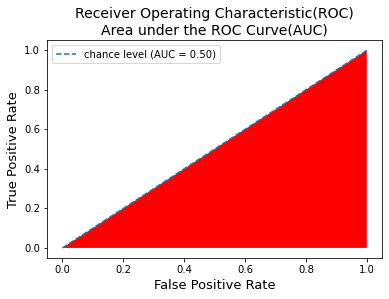

In [71]:
fpr, tpr, thresholds = roc_curve(np.array(test_generator.classes), np.array(predictions.argmax(axis=1)), pos_label=2)
auc_r = "{:.2f}".format(auc(fpr, tpr))
plt.plot(fpr,tpr, "--",label=f"chance level (AUC = {auc_r})")
plt.fill_between(fpr, tpr, facecolor='red')
##plt.axis("square")

plt.xlabel("False Positive Rate",size=13)
plt.ylabel("True Positive Rate",size=13)
plt.title("Receiver Operating Characteristic(ROC)\nArea under the ROC Curve(AUC)",size=14)
plt.legend()
plt.show()